In [1]:
import numpy as np
import pandas as pd
from skbio.stats.composition import clr
import matplotlib.pyplot as plt
import seaborn as sns
from skbio.diversity.alpha import shannon
from scipy.stats import pearsonr
from scipy.stats import mannwhitneyu
def rescale(xx):
    return(xx/xx.sum(axis=1)[:, np.newaxis] )
sns.set(rc={'axes.facecolor':'white', 
            'figure.facecolor':'white', 
            'axes.edgecolor':'black', 
            'grid.color': 'black'
            }, 
       font_scale=2)

In [2]:
df = pd.read_csv('pnas.1502875112.sd01.csv', index_col=0)
md = pd.read_csv('pnas.1502875112.sd02.txt', sep='\t', index_col=0)
md=md.loc[ md.BodySite=='Vaginal_Swab' ]
md = md.loc[md.Gestational_status_at_collection=='pregnant']
md = md.sort_values('GestationalDayOfCollection').groupby('Subject_ID').head(1)
df=df.loc[df.index.isin(md.index)]
md=md.loc[md.index.isin(df.index)].loc[df.index]
df = df.loc[:, df.sum(axis=0)> 0]

In [3]:
val=-2
(df.iloc[:, val] > 0 ).sum() ## this is a feature present in one sample

1

In [4]:
md.PretermBirth.value_counts()

False    28
True     11
Name: PretermBirth, dtype: int64

In [5]:
sh_alphas = [shannon(x) for x in df.values]

In [6]:
df.shape

(39, 222)

In [7]:
pr = pearsonr(md.PretermBirth, sh_alphas)

In [8]:
mw = mannwhitneyu( np.array(sh_alphas)[md.PretermBirth], 
                   np.array(sh_alphas)[md.PretermBirth==False]
                 )

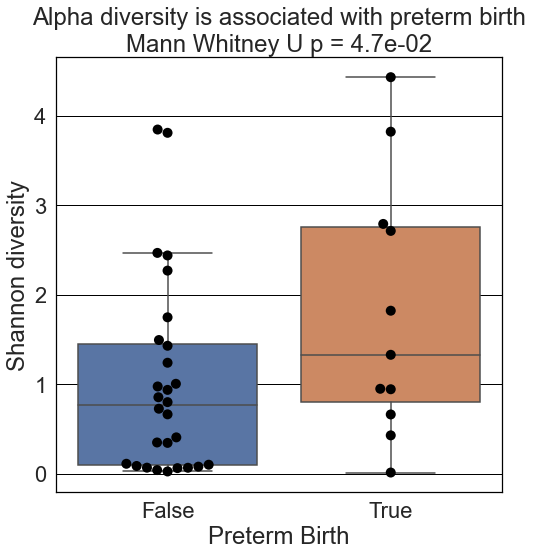

In [9]:
plt.figure(figsize=(8,8))
sns.boxplot(x = md.PretermBirth, 
            y=sh_alphas, 
            fliersize=0
           )


sns.swarmplot(x = md.PretermBirth, 
              y=sh_alphas, 
              size=10, 
              color='black'
              )
plt.ylabel('Shannon diversity')
plt.xlabel('Preterm Birth')
plt.title('Alpha diversity is associated with preterm birth\n'+\
#           'Pearson R = {:.2f}, p = {:.1e}, '.format(*pr)+\
          'Mann Whitney U p = {:.1e}'.format(mw.pvalue)
          )
plt.show()

In [10]:
X_clr = clr(rescale(df.values) + 1e-5)

In [11]:
pearsonr(md.PretermBirth, X_clr[:, -1])

(-0.07470151814658475, 0.6512941251719573)

In [12]:
mannwhitneyu(np.array(X_clr[:, val])[md.PretermBirth], 
             np.array(X_clr[:, val])[md.PretermBirth==False]
             )

MannwhitneyuResult(statistic=80.0, pvalue=0.01089840594108984)

In [13]:
pr = pearsonr(md.PretermBirth, X_clr[:, val])
mw = mannwhitneyu( np.array(X_clr[:, val])[md.PretermBirth], 
                   np.array(X_clr[:, val])[md.PretermBirth==False],
            )

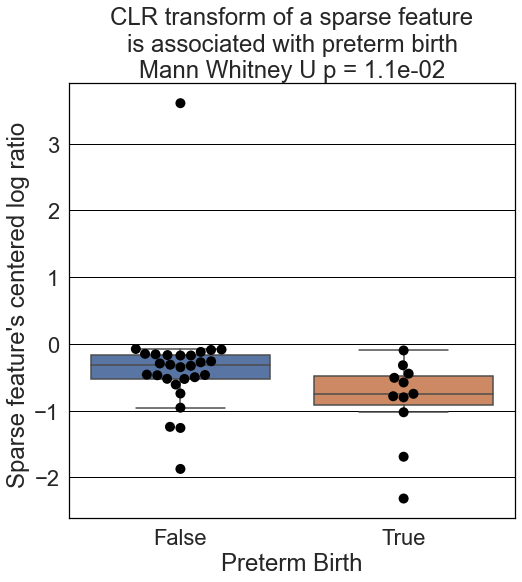

In [14]:
plt.figure(figsize=(8,8))
sns.boxplot(x = md.PretermBirth, 
            y=X_clr[:, val], 
            fliersize=0
           )


sns.swarmplot(x = md.PretermBirth, 
              y=X_clr[:, val], 
              size=10, 
              color='black'
              )
plt.ylabel("Sparse feature's centered log ratio ")
plt.xlabel('Preterm Birth')
plt.title('CLR transform of a sparse feature\nis associated with preterm birth\n'+\
#           'Pearson R = {:.2f}, p = {:.1e}, '.format(*pr)+\
          'Mann Whitney U p = {:.1e}'.format(mw.pvalue)
          )
plt.show()


In [15]:
from sklearn.linear_model import LinearRegression

In [16]:
pr = pearsonr(sh_alphas, X_clr[:, val])

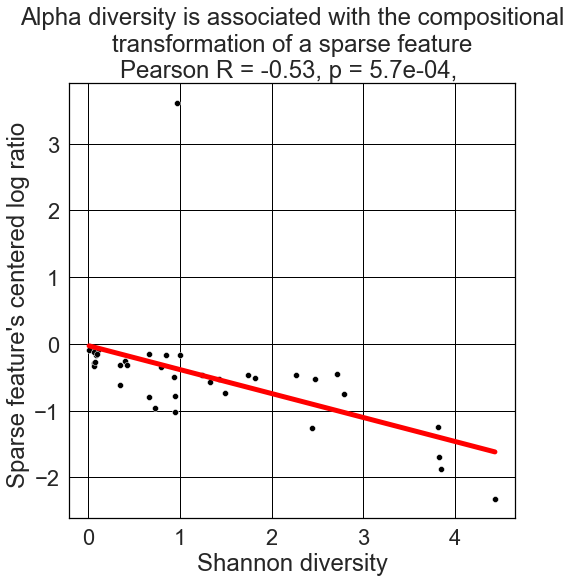

In [17]:
plt.figure(figsize=(8,8))
ax=sns.scatterplot(x = sh_alphas, 
                y=X_clr[:, val], 
                color='black',
#                 fliersize=0
               )


lr = LinearRegression()
sns.lineplot(x = sh_alphas, 
             y=lr.fit(np.array(sh_alphas)[:, np.newaxis], 
                                    X_clr[:, val])\
                         .predict(np.array(sh_alphas)[:, np.newaxis]), 
             color='red',
             linewidth=5, 
             ax=ax
               )
plt.title('Alpha diversity is associated with the compositional\ntransformation of a sparse feature\n'+\
          'Pearson R = {:.2f}, p = {:.1e}, '.format(*pr)
         )
plt.xlabel('Shannon diversity')
    
plt.ylabel("Sparse feature's centered log ratio ")
plt.show()
